# Naive bayes classifier: Google Play Store reviews

## 1. Data Loading

In [3]:
# Handle import up-front
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statistics import mean
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.model_selection import train_test_split

from helper_functions.naive_bayes import cross_val

### 1.1. Load the data

In [4]:
# Load the data from the URL provided in the project tutorial
data_df=pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/naive-bayes-project-tutorial/main/playstore_reviews.csv')

### 1.2. Inspect the data

In [5]:
data_df.head()

,package_name,review,polarity
0,com.facebook.katana,privacy at least put some option appear offli...,0
1,com.facebook.katana,"messenger issues ever since the last update, ...",0
2,com.facebook.katana,profile any time my wife or anybody has more ...,0
3,com.facebook.katana,the new features suck for those of us who don...,0
4,com.facebook.katana,forced reload on uploading pic on replying co...,0


In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   package_name  891 non-null    object
 1   review        891 non-null    object
 2   polarity      891 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 21.0+ KB


### 1.3. Train-test split

In [7]:
# Separate features from labels
labels=data_df['polarity']
features=data_df.drop('polarity', axis=1)

# Split the data into training and testing features and labels
training_features, testing_features, training_labels, testing_labels=train_test_split(
    features,
    labels,
    test_size=0.25,
    random_state=315
)

### 1.4. Data encoding

In [8]:
# Get just the reviews from the training data
training_reviews=training_features['review']

# Fit the vectorizer and transform the training reviews into word counts
vector_model=CountVectorizer(stop_words="english")
training_word_counts=vector_model.fit_transform(training_reviews).toarray()

print(f'Word count matrix has {training_word_counts.shape[0]} rows and {training_word_counts.shape[1]} columns')

Word count matrix has 668 rows and 3151 columns


In [9]:
# Get the words from the vector model
feature_names=vector_model.get_feature_names_out()

# Convert the training data word counts back into a dataframe
training_word_counts=pd.DataFrame(training_word_counts, columns=feature_names)

# Take a look...
training_word_counts.head()

,000,04,0x,10,100,101,11,113mb,1186,12,...,śŕ,şŕ,šŕ,šŕľ,źŕ,żŕ,żŕľ,žŕ,žŕľ,ˇŕ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Seems like we may have some junk features....

## 2. EDA

### 2.1. Baseline model performance

In [13]:
# Define the model
model=MultinomialNB()

# Cross-validate the model
scores=cross_val(model, training_word_counts.to_numpy(), training_labels)

Cross-validation accuracy: 80.99 +/- 4.17%


### 2.2. Review length distribution

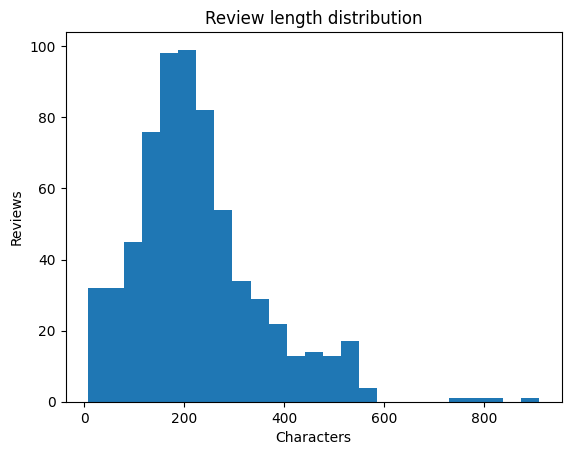

Review length mean: 227
Review length min: 8
Review length max: 910


In [14]:
# Try plotting the distribution of review lengths!

# Get the lengths (in characters)
lengths=training_features['review'].str.len().tolist()

plt.title('Review length distribution')
plt.xlabel('Characters')
plt.ylabel('Reviews')
plt.hist(lengths, bins=25)
plt.show()

print(f'Review length mean: {mean(lengths):.0f}')
print(f'Review length min: {min(lengths):.0f}')
print(f'Review length max: {max(lengths):.0f}')

From the histogram above, it's clear that:

1. We have a few extremely long reviews that could be considered 'outliers'.
2. We have some very short, or possibly zero length reviews.

Let's inspect some from each end of the distribution. If they are junk, i.e. they don't belong in a sample of reviews, we should exclude them. If they are bona fide reviews, we should keep them.

### 2.3. Long reviews

In [15]:
training_features['review_length']=lengths
long_reviews=training_features[training_features['review_length'] > 800]

In [16]:
print(long_reviews['review'].iloc[0])

  ătoo slow loading webclips!!! ăno pdf support at all... (even simpler apps do that!) ă web pages that are clipped do not adjust to current window size automatically when window is shrunk or expanded, (any program does this...geez). ă highlighting? needs more colors instead of brown mustard yellow. no customer support responses either, evernote must have been taken over by students. it's not even fun to use anymore because it is slow as hell.  this is especially for serious business users. any five star ratings down here must have been given by employees under different themes. this program has really retarded over the years. they need to stick to improving their bread and butter instead of selling side junk and features that are useless. well they got my money this time, so i have to put up with it for a few more months. the lack of pdf support really is terrible for a program like this.


In [17]:
print(long_reviews['review'].iloc[1])

 bait and switch i purchased my 3rd samsung tablet with  advertisement of free gifts, one of them being 48 additional gb cloud storage for 2 years.  the 2nd samsung tablet i bought also had this free gift and it was a nightmare to get samsung and dropbox to honor it.  so, after buying this 3rd high end tablet with the same claim of the free 48gb for 2 years in the fine print, which you can only see after purchasing the tablet, dropbox only honors the offer on the first device you purchased and you are disqualified for all future devices.  this is sleazy and bait and switch.  free= not subject to any compensation, encumbrance, repayment in kind, etc.  because of this bait and switch advertising on the part of samsung and dropbox i suggest you really find out what kind of company dropbox is before using their services.


These look fine - they are not bot spam or keyword stuffing or any other obviously non-review garbage. Let's keep them.

### 2.4. Short reviews

In [18]:
short_length=25

short_reviews=training_features[training_features['review_length'] < short_length]
short_reviews.head()


,package_name,review,review_length
755,com.shirantech.kantipur,too much pop up add,21
761,com.shirantech.kantipur,aa nice,8
851,com.hamropatro,very useful !,15
843,com.hamropatro,superb! all in one!,20
846,com.hamropatro,nice app,10


Similar story here - these are very short, but also reasonable. We should keep them.

### 2.3. Feature selection

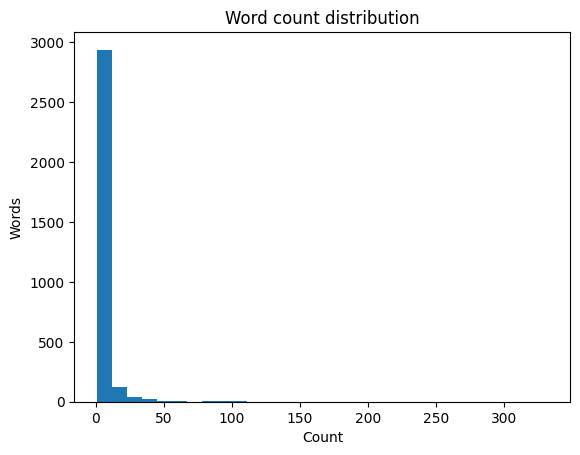

In [19]:
# After encoding we have over three thousand features - do we need all of them? Try plotting the distribution of word counts!

# Get the total count for each word
word_counts=training_word_counts.sum().tolist()

plt.title('Word count distribution')
plt.xlabel('Count')
plt.ylabel('Words')
plt.hist(word_counts, bins=30)
plt.show()


Note: this is not a great plot! This distribution spans 3 orders of magnitude and has a long tail. It's hard to see the shape of the data. In this situation, it can be more useful to plot the log:

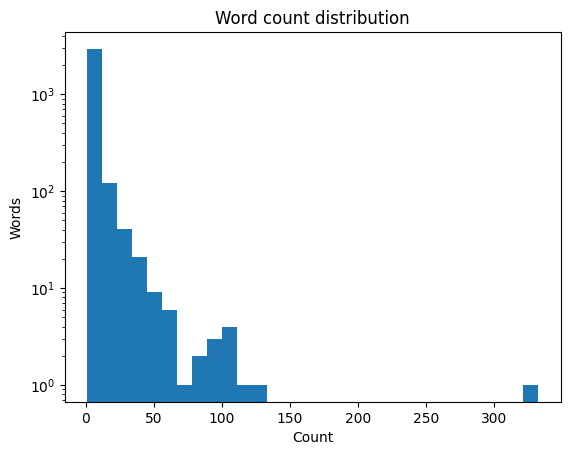

In [20]:
plt.title('Word count distribution')
plt.xlabel('Count')
plt.ylabel('Words')
plt.hist(word_counts, bins=30, log=True)
plt.show()

From the plots we can tell that we have thousands of words that occur in 10 or less of our reviews. These could be candidate features for removal, but let's take a look at some examples first and see what we are dealing with.

In [21]:
rare_words=[]

for word, count in zip(feature_names, word_counts):
    if count == 1:
        rare_words.append(word)

print(f'Have {len(rare_words)} words that only appear in one document.\n')
print(rare_words)

Have 1699 words that only appear in one document.

['000', '04', '0x', '101', '11', '113mb', '1186', '125', '14', '14th', '15mb', '180k', '1990s', '1lac', '1st', '2016', '22mb', '25', '2lac', '2m', '2many', '2nd', '30mins', '367', '3gb', '3s', '3yrs', '45', '45mb', '48gb', '50', '500k', '512kbps', '5minutes', '5star', '6mb', '82', '86', '95', 'aa', 'aakhirat', 'aapsssssss', 'abilities', 'abke', 'absolute', 'absurdly', 'accecesible', 'acces', 'accesible', 'accessing', 'accident', 'accomplish', 'accordion', 'accounts', 'accumulated', 'accurate', 'achievement', 'achive', 'act', 'activities', 'acts', 'actual', 'adage', 'adblock', 'addicted', 'addicting', 'addition', 'additional', 'addons', 'addressed', 'adequate', 'adjusting', 'adjustment', 'admin', 'admit', 'advanced', 'adventurous', 'advertising', 'adverts', 'advice', 'aesthetics', 'affirm', 'aficionado', 'age', 'agenda', 'agent', 'ahead', 'air', 'album', 'alert', 'alerts', 'allahsubhanahutallah', 'ambience', 'american', 'analysing', 'an

Many of these are actual english words, so my instinct is not to throw them out. Since we are dropping features and not examples, let's try it and see what happens to the cross-validation performance.

In [23]:
# Define the model
model=MultinomialNB()

# Cross-validate the model
scores=cross_val(model, training_word_counts.drop(rare_words, axis=1).to_numpy(), training_labels)

Cross-validation accuracy: 81.14 +/- 4.74%


Tiny improvement. Let's try looking at the top  common words:

In [24]:
threshold=100
common_words=[]

for word, count in zip(feature_names, word_counts):
    if count >= threshold:
        common_words.append(word)

print(f'Have {len(common_words)} words that appear in {threshold} or more documents.\n')
print(common_words)

Have 7 words that appear in 100 or more documents.

['app', 'fix', 'game', 'good', 'like', 'new', 'update']


Yeah, thinking we should probably leave those alone. Let's try one more feature selection/engineering strategy before we move on:

In [25]:
svd=TruncatedSVD(n_components=1000)
fit_result=svd.fit(training_word_counts.drop(rare_words, axis=1))

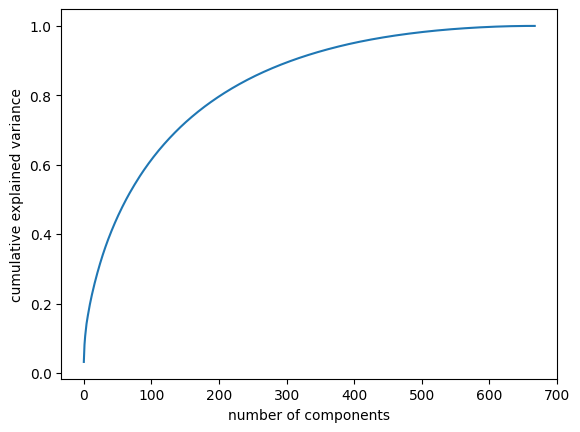

In [26]:
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [27]:
svd=TruncatedSVD(n_components=600)
training_words_svd=svd.fit_transform(training_word_counts.drop(rare_words, axis=1))

In [28]:
training_words_svd += abs(np.min(training_words_svd))

In [29]:
# Define the model
model=GaussianNB()

# Scale the data to make it non-negative
training_words_svd += abs(np.min(training_words_svd))

# Cross-validate the model
scores=cross_val(model, training_words_svd, training_labels)

Cross-validation accuracy: 66.92 +/- 5.27%


Nope - didn't help. One more feature engineering idea - we have been ignoring the app feature. Let's try using it!

In [30]:
encoded_package_name=pd.get_dummies(training_features['package_name'], dtype=int)
encoded_package_name.reset_index(drop=True, inplace=True)
word_count_package_name=training_word_counts.join(encoded_package_name)

In [32]:
# Define the model
model=MultinomialNB()

# Cross-validate the model
scores=cross_val(model, word_count_package_name.to_numpy(), training_labels)

Cross-validation accuracy: 83.69 +/- 3.70%


Nice! Ok, cool - there was definitely some good information there! I have one more idea - what if the length of the review matters? We could add a new set of dummy features for short, medium and long?

In [33]:
quantiles=[0, 0.25, 0.50, 0.75, 1]
bins=training_features['review_length'].quantile(quantiles)

labels = ['short_bin', 'medium_bin', 'long_bin', 'extralong_bin']
training_features['length_bin']=pd.cut(training_features['review_length'], bins=bins, labels=labels)

encoded_length_bin=pd.get_dummies(training_features['length_bin'], dtype=int)
encoded_length_bin.reset_index(drop=True, inplace=True)

word_count_package_name_length_bin=word_count_package_name.join(encoded_length_bin)

In [35]:
# Define the model
model=MultinomialNB()

# Cross-validate the model
scores=cross_val(model, word_count_package_name_length_bin.to_numpy(), training_labels)

Cross-validation accuracy: 83.54 +/- 4.02%


Nope - didn't help. Maybe we can revisit this later - I have more ideas for engineered features, but I think that's enough for now.

## 5. Model optimization

In [37]:
multinomial_model=MultinomialNB()
multinomial_scores=cross_val(multinomial_model, word_count_package_name.to_numpy(), training_labels)

Cross-validation accuracy: 83.69 +/- 3.70%


In [38]:
gaussian_model=GaussianNB()
gaussian_scores=cross_val(gaussian_model, word_count_package_name.to_numpy(), training_labels)

Cross-validation accuracy: 75.30 +/- 3.33%


In [39]:
bernoulli_model=BernoulliNB()
bernoulli_scores=cross_val(bernoulli_model, word_count_package_name.to_numpy(), training_labels)

Cross-validation accuracy: 79.49 +/- 3.56%


## 5. Final model evaluation